# 비대칭 데이터 문제 #

## 1. 비대칭 데이터 생성 ##

In [4]:
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.under_sampling import *
from imblearn.over_sampling import *
import time

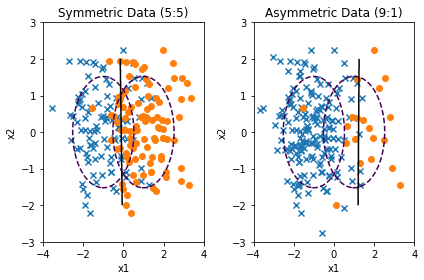

In [5]:
def classification_result(n0, n1, title=""):
    rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
    rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
    X0 = rv1.rvs(n0, random_state=0)
    X1 = rv2.rvs(n1, random_state=0)
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n0), np.ones(n1)])

    x1min = -4; x1max = 4
    x2min = -2; x2max = 2
    xx1 = np.linspace(x1min, x1max, 1000)
    xx2 = np.linspace(x2min, x2max, 1000)
    X1, X2 = np.meshgrid(xx1, xx2)

    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")

    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="Class 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="Class 1")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    
    return model, X, y, y_pred
    
plt.subplot(121)
model1, X1, y1, y_pred1 = classification_result(100, 100, "Symmetric Data (5:5)")
plt.subplot(122)
model2, X2, y2, y_pred2 = classification_result(180, 20, "Asymmetric Data (9:1)")
plt.tight_layout()
plt.show()

In [6]:
## 생성된 데이터의 분포 ##
print('y1의 분포 : ', dict(Counter(y1)))
print('y2의 분포 : ',dict(Counter(y2)))

y1의 분포 :  {0.0: 100, 1.0: 100}
y2의 분포 :  {0.0: 180, 1.0: 20}


Symmetric은 5:5, Asymmetric은 9:1의 분포를 보임

## 2. SVC 모델로 분류 및 결과 보기 ##

In [7]:
print('Model1 \n', classification_report(y1, y_pred1))
print('Model2 \n', classification_report(y2, y_pred2))

Model1 
               precision    recall  f1-score   support

         0.0       0.86      0.79      0.82       100
         1.0       0.81      0.87      0.84       100

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200

Model2 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       180
         1.0       0.75      0.60      0.67        20

    accuracy                           0.94       200
   macro avg       0.85      0.79      0.82       200
weighted avg       0.94      0.94      0.94       200



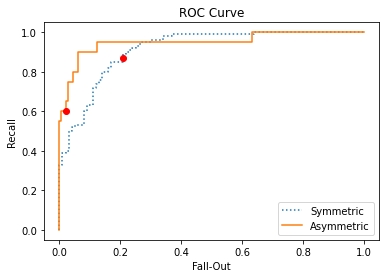

In [8]:
from sklearn.metrics import roc_curve, confusion_matrix

fpr1, tpr1, thresholds1 = roc_curve(y1, model1.decision_function(X1))
fpr2, tpr2, thresholds2 = roc_curve(y2, model2.decision_function(X2))

c1 = confusion_matrix(y1, y_pred1, labels=[1, 0])
c2 = confusion_matrix(y2, y_pred2, labels=[1, 0])
r1 = c1[0, 0] / (c1[0, 0] + c1[0, 1])
r2 = c2[0, 0] / (c2[0, 0] + c2[0, 1])
f1 = c1[1, 0] / (c1[1, 0] + c1[1, 1])
f2 = c2[1, 0] / (c2[1, 0] + c2[1, 1])

plt.plot(fpr1, tpr1, ':', label="Symmetric")
plt.plot(fpr2, tpr2, '-', label="Asymmetric")
plt.plot([f1], [r1], 'ro')
plt.plot([f2], [r2], 'ro')
plt.legend()
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.show()

Model2의 1그룹의 Precision과 Recall이 매우 떨어짐 (1그룹의 수가 적어서 발생)  
이런 경우 Oversampling(1그룹을 늘림), Undersampling(0그룹을 줄임)을 통해 해결 

## 3. Undersampling ##

### 1. Random Under Sampling ###
### 무작위로 데이터를 없애서 비율을 맞춤 ##

In [9]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X2, y2)
print('y_rus의 분포 : ',dict(Counter(y_rus)))

y_rus의 분포 :  {0.0: 20, 1.0: 20}


0그룹을 삭제하여 데이터 비율을 1:1로 맞춤

### 2. Tomek's link method ###
### 서로 다른 그룹의 데이터가 가깝게 붙어 있으면 다수 그룹의 데이터를 삭제 ###

In [10]:
tom = TomekLinks()
X_tom, y_tom = tom.fit_resample(X2, y2)
print('y_tom의 분포 : ',dict(Counter(y_tom)))

y_tom의 분포 :  {0.0: 173, 1.0: 20}


경계선의 0그룹 소속 7개 데이터 삭제

### 3. Condensed Nearest Neighbor ###
### 소수 그룹의 Neighbor을 구해서 그 Neighbor과 가까운 다수 그룹 데이터를 변경 ###

In [11]:
CNN = CondensedNearestNeighbour()
X_CNN, y_CNN = CNN.fit_resample(X2, y2)
print('y_CNN의 분포 : ',dict(Counter(y_CNN)))

y_CNN의 분포 :  {0.0: 29, 1.0: 20}


1그룹 Neighbor과 가까운 0그룹 소속 150개 데이터 삭제

## 4. Oversampling ##

### 1. Random Over Sampling ###
### 적은 그룹의 데이터를 반복해서 넣어 비율을 맞춤 ###
### 데이터를 Random으로 복제해서 넣는 것이어서 일부 데이터의 힘이 커지는 문제가 발생할 수 있음 ###

In [12]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X2, y2)
print('y_ros의 분포 : ',dict(Counter(y_ros)))

y_ros의 분포 :  {0.0: 180, 1.0: 180}


1그룹 데이터 숫자를 반복하여 비율을 맞춤

### 2. Adaptive Synthetic Sampling ###
### 적은 그룹의 데이터끼리 직선을 만들어 그 직선 안에서 가상의 데이터 생성 ###

In [13]:
AS = ADASYN(random_state=42)
X_AS, y_AS = AS.fit_resample(X2, y2)
print('y_AS의 분포 : ',dict(Counter(y_AS)))

y_AS의 분포 :  {0.0: 180, 1.0: 180}


1그룹 내 가상 데이터를 만들어 비율을 맞춤

### 3. Synthetic Minority Over-sampling Technique (SMOTE) ###
### 분류 모형에 따라 데이터를 생성 ###

In [14]:
SM = SMOTE(random_state=42)
X_SM, y_SM = SM.fit_resample(X2, y2)
print('y_SM의 분포 : ',dict(Counter(y_SM)))

y_SM의 분포 :  {0.0: 180, 1.0: 180}


## 5. Samling data로 분류 후 정확성 판단 ##

### 1. Undersampling data로 정확성 판단 ###
### y_tom의 분포 :  {0.0: 173, 1.0: 20} ###

In [15]:
model = SVC(kernel="linear", C=1e4, random_state=0).fit(X_tom, y_tom)
y_pred = model.predict(X_tom)
print("Confusion matrix \n",confusion_matrix(y_tom, y_pred))
print("Precision : ", precision_score(y_tom, y_pred))
print("Recall score : ", recall_score(y_tom, y_pred))
print("F1 : ", f1_score(y_tom, y_pred))

Confusion matrix 
 [[170   3]
 [  6  14]]
Precision :  0.8235294117647058
Recall score :  0.7
F1 :  0.7567567567567567


0 그룹의 비율이 여전히 압도적으로 높아 정확도가 낮다.

### 2. Oversampling data로 정확성 판단 ###
### y_SM의 분포 :  {0.0: 180, 1.0: 180} ###

In [17]:
start = time.time()
model = SVC(kernel="linear", C=1e4, random_state=0).fit(X_SM, y_SM)
y_pred = model.predict(X_SM)
end = time.time()
print("Confusion matrix \n",confusion_matrix(y_SM, y_pred))
print("Precision : ", precision_score(y_SM, y_pred))
print("Recall score : ", recall_score(y_SM, y_pred))
print("F1 : ", f1_score(y_SM, y_pred))
print("Execution time : ", end-start)

Confusion matrix 
 [[164  16]
 [ 10 170]]
Precision :  0.9139784946236559
Recall score :  0.9444444444444444
F1 :  0.9289617486338798
Execution time :  0.5097079277038574


두 그룹 간의 비율이 비슷해져서 정확도가 높아진다.

## 6. 관련 이론 ##

1. Undersampling

위의 예시에서도 그렇듯 많은 양의 원데이터가 사라지고, 이는 많은 양의 정보가 사라지는 문제가 생긴다.  

각 그룹 간의 경계선에 있는 데이터가 사라지게 될 경우 이는 분류를 더 어렵게 만들 수 있다.

또한 소수 그룹의 데이터가 극단적으로 적다면 fitting할 total 데이터 수가 적어진다는 문제가 있다.

2. Oversampling

편향된 데이터에 영향을 많이받는 ML 분류모델, 인공망 모델 세울 때 Over/Under Sampling은 굉장히 강력하다. 

그러나 적은 그룹의 목소리를 키워주는 절차여서 수가 적은 그룹으로 향하게 Overfitting 되는 부작용이 있을 수 있다.

또한 비슷한 성질을 띄는 소수 그룹을 반복해서 만드는 것이고, 그 데이터에 대해서도 데이터를 fitting해야해서 계산 비용이 추가적으로 더 들수 있다.

3. 기타

다수 그룹을 적절히 줄이고 동시에 소수 그룹을 적절히 늘리는 Mixed Sampling이 대안이 될 수 있다.

또한 원데이터 삭제 & 새로운 데이터 창조 라는 부작용이 있기에 기존의 변수를 조합해 새로운 변수를 사용하던지, 차원 축소를 하는 것이 대안이 될 수 있다.

Undersampling은 특히 Cost가 크다. (에러가 높다..)
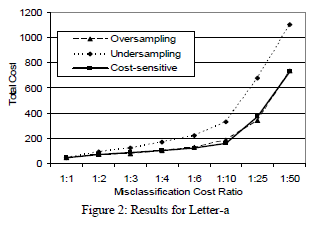